<a href="https://colab.research.google.com/github/nargyanti/IPCV_Genap_2022/blob/main/PCVK_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Leaf Detection using Shi-Tomashi Corner**


*   Nabilah Argyanti Ardyningrum
*   Rizki Irfan Maulana



## Import library and mounting drive

In [1]:
# Import library
import cv2 as cv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import glob

In [2]:
# Mount drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Functions

### Append the images to array

In [3]:
# Append image to array
def append_images_to_array(subfolder):
  path = '/content/drive/MyDrive/PCVK/Dataset/Leaf Images 05/' + subfolder + '/*.jpg'
  images = []
  for i in glob.glob(path):    
    n = cv.imread(i)
    images.append(n)
  return images

### Shi-Tomashi corner detection

In [4]:
# Detect Shi-Tomashi corner
def shi_tomashi(img):  
  img = cv.GaussianBlur(img, (21, 21), 0)
  img_gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)

  corners = cv.goodFeaturesToTrack(img_gray, 1000, 0.01, 10)
  corners = corners.astype(np.int0)
  return corners

In [5]:
# Count corner for Shi-Tomashi corner
def count_corner(corners):    
  count = 0
  for i in corners:      
      count += len(i)
  return count

In [6]:
# Draw Shi-Tomashi corner to image
def draw_corner(img, corners):  
  image = img.copy()
  for i in corners:
      x,y = i.ravel()      
      cv.circle(image,(x,y),3,255, 2)   
  return image

## Image Classification

### 1. Import images

In [7]:
# List folder name
leaves = ['Ginkgo_Biloba', 'Ilex_Aquifolium', 'Liquidambar_Styraciflua']

# Append each image to array
images_ginkgo = append_images_to_array(leaves[0])
images_ilex = append_images_to_array(leaves[1])
images_liquidambar = append_images_to_array(leaves[2])

### 2. Detect Shi-Tomashi corner

In [8]:
# Detect Shi-Tomashi corner to get the range of corner in each image group
def train(images):
  images_input = images
  result = []
  amount = []

  for img in images_input:
    corners = shi_tomashi(img)
    img_result = draw_corner(img, corners)
    corner_count = count_corner(corners)
    result.append(img_result)
    amount.append(corner_count)

  output = [amount, result]
  return output

In [9]:
# Train each image group from 3rd image until end
result_ginkgo_train = train(images_ginkgo[2:])
result_ilex_train = train(images_ilex[2:])
result_liquidambar_train = train(images_liquidambar[2:])

In [10]:
# Print corner amount of each image
print(np.sort(result_ginkgo_train[0]))
print(np.sort(result_ilex_train[0]))
print(np.sort(result_liquidambar_train[0]))

# Define max and min of leaves
min_ginkgo = np.min(result_ginkgo_train[0]) # 44
min_ilex = np.min(result_ilex_train[0]) # 23
min_liquidambar = np.min(result_liquidambar_train[0]) # 141

[44 57 58 59 59 61 61 62 64 64 65 67 70 72]
[23 26 28 30 30 32 34 34 37 38 39 41 42]
[141 145 150 154 157 162 164 167 171 181 182 205 212 242]


## Testing

Saving Ilex_Aquifolium_01.ab.jpg to Ilex_Aquifolium_01.ab.jpg
Corner amount:  30
Ilex Aquifolium


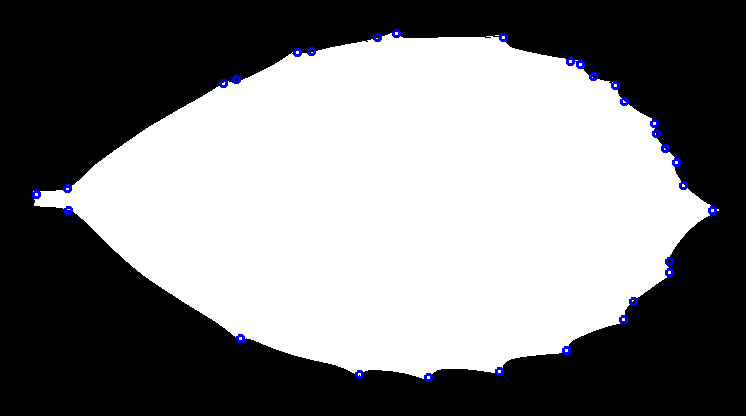

In [26]:
# Main program
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img_test = cv.imread(path)
  corner_test = shi_tomashi(img_test)
  corner_count_test = count_corner(corner_test)
  img_result = draw_corner(img_test, corner_test)
  
  print('Corner amount: ', corner_count_test)  
  if corner_count_test >= min_liquidambar:
    print('Liquidambar Styraciflua')
  elif corner_count_test >= min_ginkgo:
    print('Ginkgo Biloba')
  else:
    print('Ilex Aquifolium')

  cv2_imshow(img_result)  

#**Leaf Detection using Machine Learning**

In [12]:
import tensorflow as tf
import zipfile
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)

2.8.2


In [13]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
base_dir = '/content/drive/MyDrive/PCVK/Dataset/Leaf Images 05'

In [15]:
# View the contents of base_dir directory
os.listdir(base_dir)

['Liquidambar_Styraciflua', 'Ginkgo_Biloba', 'Ilex_Aquifolium']

In [16]:
# Augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range = 20,
            vertical_flip = True,
            horizontal_flip = True,
            shear_range = 0.2,
            fill_mode = 'nearest',
            validation_split = 0.2) 

In [17]:
# Prepare training data and data validation that will be learned by the model
train_generator = datagen.flow_from_directory(
                    base_dir,
                    target_size = (150, 150), 
                    batch_size = 4,
                    color_mode ='grayscale',
                    class_mode = 'categorical',                    
                    subset='training') 

validation_generator = datagen.flow_from_directory(
                    base_dir,
                    target_size = (150, 150), 
                    batch_size = 4,
                    color_mode ='grayscale',
                    class_mode = 'categorical',                    
                    subset='validation')

Found 38 images belonging to 3 classes.
Found 9 images belonging to 3 classes.


In [18]:
# Create CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),    
    tf.keras.layers.Dense(3, activation='softmax'),    
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [19]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [20]:
# Train the model using fit method
model.fit(
      train_generator,
      steps_per_epoch=3, 
      epochs=15,       
      verbose=1)

Epoch 1/15
3/3 [==============================] - 1s 178ms/step - loss: 1.2918 - accuracy: 0.3333
Epoch 2/15
3/3 [==============================] - 1s 171ms/step - loss: 1.1139 - accuracy: 0.4167
Epoch 3/15
3/3 [==============================] - 1s 174ms/step - loss: 0.7344 - accuracy: 0.7500
Epoch 4/15
3/3 [==============================] - 1s 166ms/step - loss: 0.8918 - accuracy: 0.6667
Epoch 5/15
3/3 [==============================] - 1s 179ms/step - loss: 0.2823 - accuracy: 1.0000
Epoch 6/15
3/3 [==============================] - 1s 167ms/step - loss: 0.1667 - accuracy: 1.0000
Epoch 7/15
3/3 [==============================] - 0s 141ms/step - loss: 0.1982 - accuracy: 0.9000
Epoch 8/15
3/3 [==============================] - 0s 173ms/step - loss: 0.5415 - accuracy: 0.7000
Epoch 9/15
3/3 [==============================] - 0s 140ms/step - loss: 0.0134 - accuracy: 1.0000
Epoch 10/15
3/3 [==============================] - 0s 138ms/step - loss: 0.1530 - accuracy: 0.9000
Epoch 11/15
3/3 [==

In [21]:
# Check accuracy score for train_generator
train_score = model.evaluate(train_generator)

10/10 [==============================] - 1s 53ms/step - loss: 0.0108 - accuracy: 1.0000


Saving Liquidambar_Styraciflua_16.ab.jpg to Liquidambar_Styraciflua_16.ab.jpg
Liquidambar_Styraciflua_16.ab.jpg
Liquidambar Styraciflua


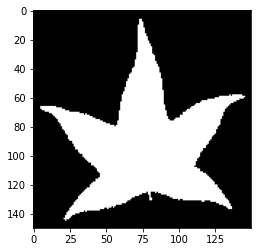

In [23]:
# Main program
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)   
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)  

  images = np.vstack([x])
  images = tf.image.rgb_to_grayscale(images)
  classes = model.predict(images, batch_size=4)

  print(fn)
  if classes[0,0]==1:
    print('Ginkgo Biloba')
  elif classes[0,1]==1:
    print('Ilex Aquifolium')
  else:
    print('Liquidambar Styraciflua')